# Correct weighting for large DMs and boxcars
Includes clancys answer - see below.

In [164]:
import numpy as np
from pylab import *
import fdmt
import boxcar
import simfrb
%matplotlib inline

nf = 256 # number of channels - must be a power of 2 currently.
fmax = 1448. +0.5#  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 256 # Number of samples per block
tsamp = 1.0 # milliseconds
reload(fdmt)
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt, history_dtype=np.float32) # make FDMT
for i, s in enumerate(thefdmt.hist_state_shape):
    print 'Iteration', i, 'shape=', s, 'total elements=', s.prod()

Iteration 0 shape= [256   7 263] total elements= 471296
Iteration 1 shape= [128  12 268] total elements= 411648
Iteration 2 shape= [ 64  23 279] total elements= 410688
Iteration 3 shape= [ 32  44 300] total elements= 422400
Iteration 4 shape= [ 16  85 341] total elements= 463760
Iteration 5 shape= [  8 165 421] total elements= 555720
Iteration 6 shape= [  4 317 573] total elements= 726564
Iteration 7 shape= [  2 587 843] total elements= 989682
Iteration 8 shape= [   1 1024 1280] total elements= 1310720


In [165]:
def printmax(msg, v):
    imax = np.argmax(v)
    ipos = np.unravel_index(imax, v.shape)
    print(msg, 'max=', v.max(), 'at', ipos)


def plot_fdmt_osum(thefdmt, longfrb, osum_vmax=None):

    # Next, we'll block it up in the way the FDMT does it
    nsamples = longfrb.shape[1]
    nblocks = nsamples/nt

    
    fig, axs = subplots(3,nblocks, figsize=(18,12))
    theoverlap = fdmt.OverlapAndSum(nd, nt) # Make overlap and sum operator
    plotdm = slice(0, 200) # Only plot the interesting DMs
    frbsum = longfrb.sum()
    
    outblocks = []
    foutblocks = []

    for blk in range(nblocks):
        din = longfrb[:, blk*nt:(blk+1)*nt] # chop out this block the the fdmt
        fout = thefdmt(din)
        overlap_out = theoverlap(fout).copy() # need to add copy otherwise matplotlib deeply confused.
        
        print('FRBSUM', frbsum, 'Input sum', din.sum())
        printmax('blk {} Fout'.format(blk), fout)
        printmax('blk {} overlap out'.format(blk), overlap_out)
        printmax('blk {} overlap history'.format(blk), theoverlap.history)
        

        outblocks.append(overlap_out)
        foutblocks.append(fout)

        axs[0, blk].imshow(din, aspect='auto', origin='lower')
        axs[1, blk].imshow(fout, aspect='auto', origin='lower')
        axs[2, blk].imshow(overlap_out, aspect='auto', origin='lower', vmax=osum_vmax)

        axs[2, blk].set_xlabel('Time (samples)')

        axs[0, blk].set_title('Block {}'.format(blk))

        if blk == 0:
            axs[0, blk].set_ylabel('Input. (channel)')
            axs[1, blk].set_ylabel('FDMT output (idt)')
            axs[2, blk].set_ylabel('Overlap output (idt)')
            
    return np.array(outblocks), np.array(foutblocks)

FRBSUM 328218.0 Input sum 65695.0
blk 0 Fout max= 316.0 at (1021, 1021)
blk 0 overlap out max= 274.0 at (252, 253)
blk 0 overlap history max= 316.0 at (1021, 1021)
FRBSUM 328218.0 Input sum 65670.0
blk 1 Fout max= 274.0 at (256, 255)
blk 1 overlap out max= 439.0 at (507, 252)
blk 1 overlap history max= 584.0 at (1022, 766)
FRBSUM 328218.0 Input sum 65653.0
blk 2 Fout max= 273.0 at (252, 252)
blk 2 overlap out max= 518.0 at (711, 225)
blk 2 overlap history max= 820.0 at (1022, 510)
FRBSUM 328218.0 Input sum 65664.0
blk 3 Fout max= 275.0 at (256, 255)
blk 3 overlap out max= 1076.0 at (1023, 255)
blk 3 overlap history max= 1076.0 at (1023, 255)
FRBSUM 328218.0 Input sum 65536.0
blk 4 Fout max= 273.0 at (256, 255)
blk 4 overlap out max= 820.0 at (1023, 0)
blk 4 overlap history max= 820.0 at (1023, 0)


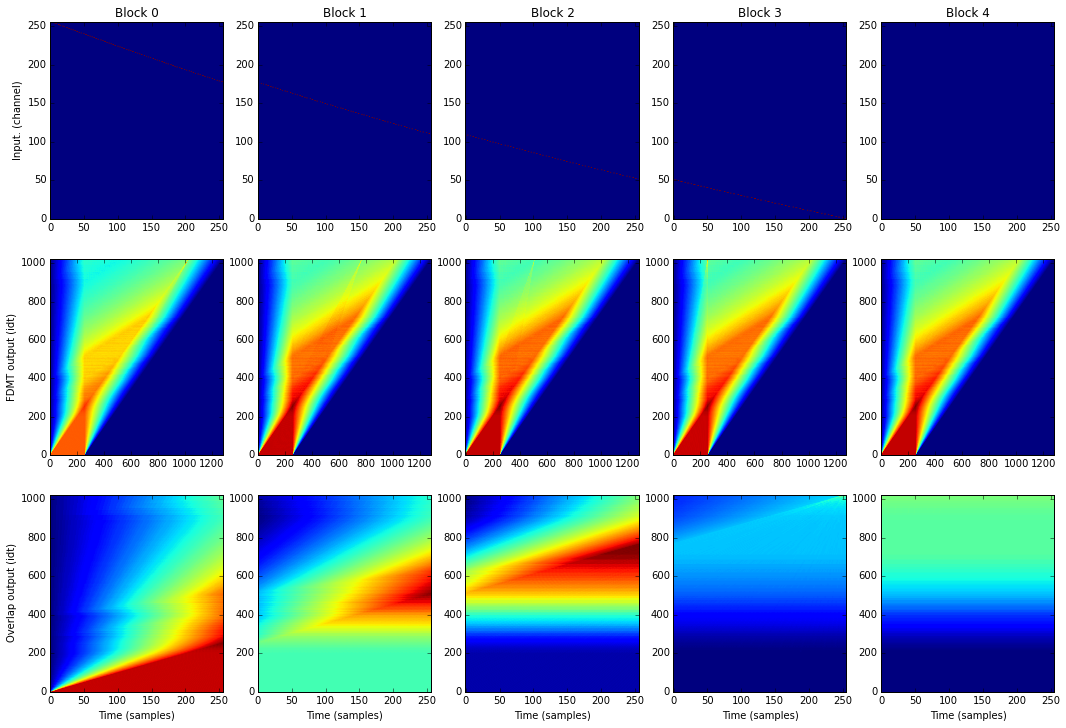

In [172]:
idt = nd - 1
frb0 = np.zeros((nf, nd+nt), dtype=np.float32)
thefdmt.add_frb_track(idt, frb0)
frbsum = (frb0.sum()-np.prod(frb0.shape))*2
frbboxcar = boxcar.Boxcar(nf, nbox=32)
frb = frb0
blocks, fblocks = plot_fdmt_osum(thefdmt, frb)

(1024, 256)
blockmax 538.0
frbsum 538.0
all zeros? False


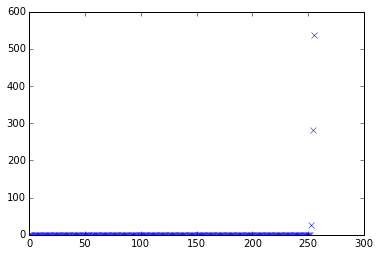

In [169]:
oout = blocks[-2, :, :]
print(oout.shape)
plot(oout[idt, :].T,'x')
print('blockmax', blocks[:, :, :].max())
print('frbsum', frb.sum())
print("all zeros?", np.all(oout == 0))

# And clancy has the answer

In his email of 1 April 2020 16:53

Hey Keith,

OK, this is about how to calculate the appropriate number of trials - another email shortly on how to calculate that.

It’s “easy”:
$\sqrt{ \sum_{i,j} z_{i,j}^2 }$


where i sums over time, j sums over frequency, and z is an INTEGER weight counting the number of times things are counted. It’s annoying to calculate, but doable.

For example, for a SINGLE frequency channel of DM smearing of $N=5$ samples, the standard weighting is:
0 0 0 0 1 1 1 1 1 0 0 0 0
for a “no boxcar” (w=1) search, i.e. std dev of $\sqrt{5}$ for 5 independent samples.

The next search in time has weights of
0 0 0 0 0 1 1 1 1 1 0 0 0
So for a w=2 search, we get
0 0 0 0 1 2 2 2 2 1 0 0 0
for std dev of $\sqrt{1^2 +2^2+…+1^2 = 18}$, almost 2*w=1!

For w=3 it is:
0 0 0 0 1 2 3 3 3 2 1 0 0
which means a sigma of $\sqrt{37}$
etc

The exact formula for the number in the square root is:
$(N-W+1)*W^2+(2*W-1)*W*(W-1)/3 $  (possibly simplifies to something)
In the case that W>N, then we need to swap N and W in the above, i.e. if we define:
$H=max(N,W)$
$L=min(N,W)$
the variance becomes
$(H-L+1)*L^2+(2*L-1)*L*(L-1)/3$

A function to calculate this for a given DM/width would be:
```C

// calculate effective sigma for a DM search over Nchan channels with integer channel smearing and a width search of w
// note here W begins at 1 not at 0
int get_eff_sigma(int width, int Nchan,  int *channel_smearing_factors)
	{
	int i;
	int eff_sigma=0;
        int H,L;
	int var_chan;
	int total_var=0;
	for (i=0 i<Nchan; i++)
		{
		//  work out which is biggest
		if (channel_smearing_factors[i] > width)
			{
			H=channel_smearing_factors[i];
			L=width
			}
		else
			{
			L=channel_smearing_factors[i];
			W=width
			}
		var_chan = (H-L+1)*L^2+(2*L-1)*L*(L-1)/3
		total_var += var_chan;
		}
	eff_sigma = pow(float(total_var),0.5);
	return eff_sigma;
```

Cheers,
Clancy

# Trialing clancys method

In [44]:
# get effetive sigma - python version of Clancy's code
def get_eff_sigma(thefdmt, idt, width):
    assert width > 0
    assert 0 <= idt < thefdmt.max_dt
    nchan = thefdmt.n_f
    nodes = thefdmt.trace_dm(idt)
    smearing = [n[1]+1 for n in nodes]
    total_var = 0
    for chan in range(nchan):
        if smearing[chan] > width:
            H = smearing[chan]
            L = width
        else:
            L = smearing[chan]
            H = width
            
        assert H > 0
        assert L > 0
        
        var_chan = (H-L+1)*(L**2) + (2*L - 1)*L*(L-1)/3
        total_var += var_chan
    
    eff_sigma = pow(float(total_var),0.5)
    
    return eff_sigma

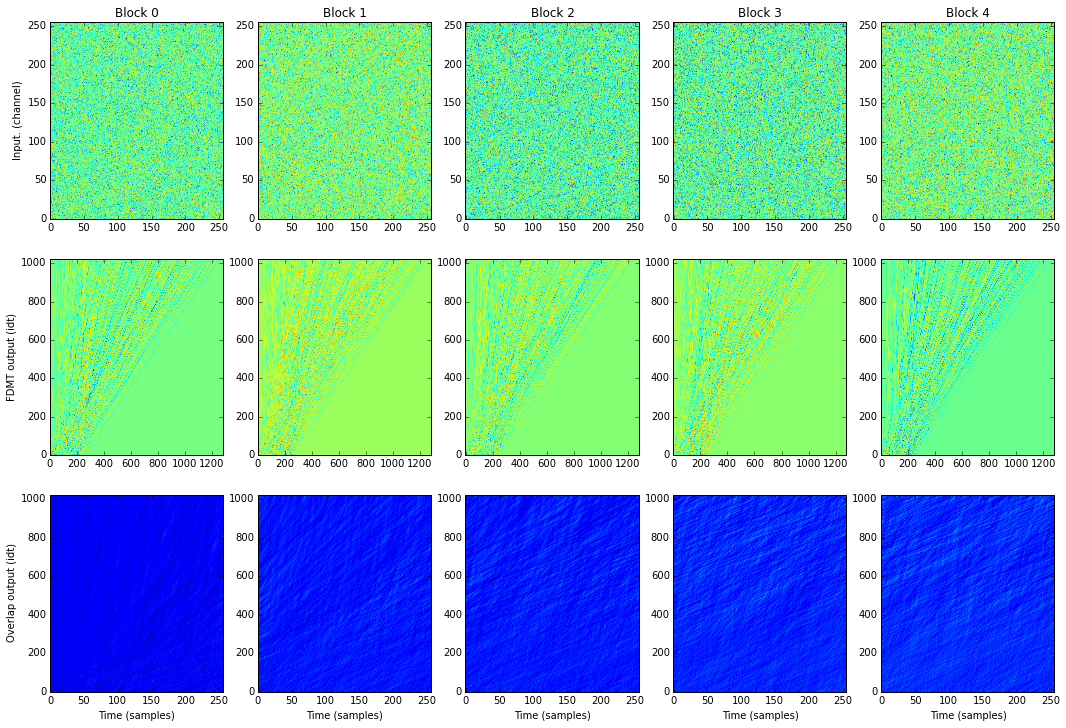

In [45]:
noise = np.random.randn(nf, nd + nt).astype(np.float32)
noise_output = plot_fdmt_osum(thefdmt, noise, osum_vmax=nd/2)


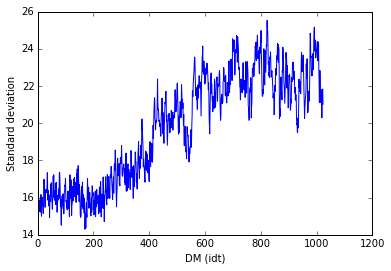

In [46]:
# Let's look at the standard deviation of the final block vs DM
plot(noise_output[-1, :, :].std(axis=1))
xlabel('DM (idt)')
ylabel('Standard deviation')

In [47]:
# create a boxcar - this has a history in it so it remembers the last few samples of a block
nbox = 32
theboxcar = boxcar.Boxcar(nd, nbox=nbox, dtype=np.float32)

#push the block through the boxcar
bcout = np.array([theboxcar(noise_output[d, :, :].astype(np.float32)) \
                  for d in range(noise_output.shape[0])])
bcout_weighted = bcout

In [48]:
weights = np.zeros((nd, nbox), dtype=np.float32)
for idt in range(thefdmt.max_dt):
    for w in range(nbox):
        weights[idt, w] = get_eff_sigma(thefdmt, idt, w+1)

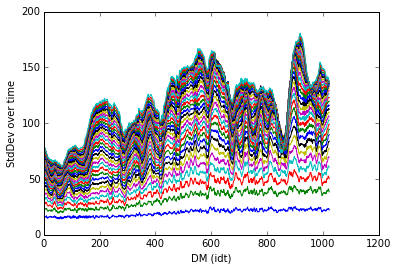

In [41]:
# Plot stddev over time vs DM and boxcar
bcstd = bcout[-1, :, :, :].std(axis=1)
_ = plot(bcstd)
xlabel('DM (idt)')
ylabel('StdDev over time')


In [42]:
print(bcout.shape)
bcout_weighted = bcout/weights[np.newaxis, :, np.newaxis, :]

(5, 1024, 256, 32)


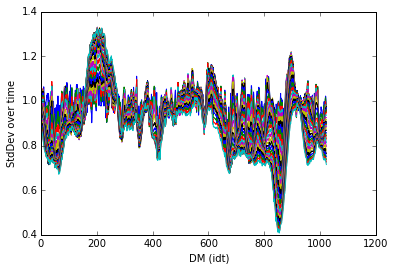

In [43]:
bcwstd = bcout_weighted[-1, :, :, :].std(axis=1)
_ = plot(bcwstd)
xlabel('DM (idt)')
ylabel('StdDev over time')

(1024, 32)


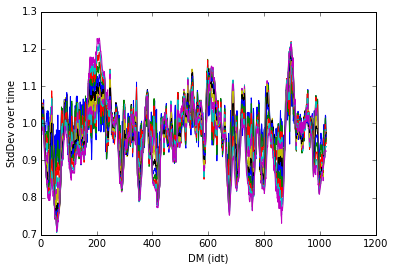

In [50]:
print(bcwstd.shape)
_ = plot(bcwstd[:, 0:12])
xlabel('DM (idt)')
ylabel('StdDev over time')

# Here it is with a pulse and some noise.

In [75]:
width = 10
frb = frbwide[:,:,width]
newfrb = frb + np.random.randn(frb.shape[0], frb.shape[1]).astype(np.float32)

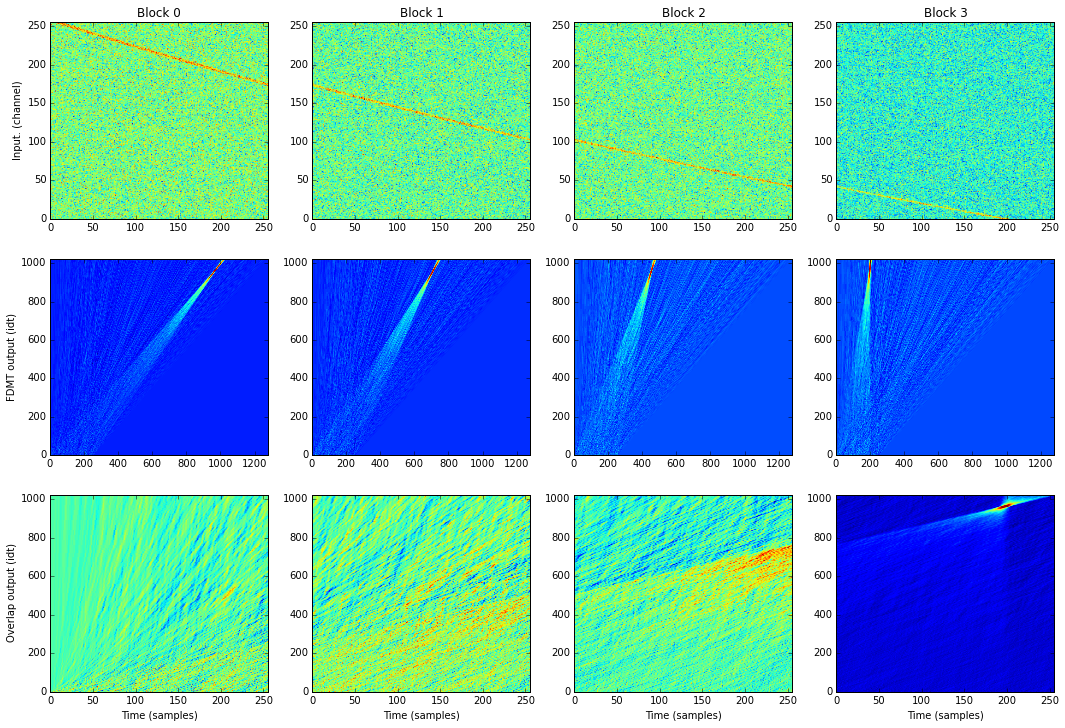

In [76]:
frbout = plot_fdmt_osum(thefdmt, newfrb)

In [77]:
bcout = np.array([theboxcar(frbout[d, :, :].astype(np.float32)) \
                  for d in range(frbout.shape[0])])
bcout_weighted = bcout/weights[np.newaxis, :, np.newaxis, :]

In [78]:
print('max value is', bcout_weighted.max(), 'at', np.unravel_index(bcout_weighted.argmax(), bcout.shape))

max value is 107.26929 at (3, 960, 202, 10)
